First, we complete OAuth Authentication and API setup for fine tuning a Gemini model on our data

In [33]:
import os
import google.generativeai as genai
from load_creds import load_creds, load_iam_creds

# Load credentials
creds = load_iam_creds()

# Configure generative AI with credentials
genai.configure(credentials=creds)

print()
print('Available base models:', [m.name for m in genai.list_models()])

print()
print('Available tuned models:')
try:
    tuned_models = genai.list_tuned_models()
    for i, model in enumerate(tuned_models):
        print(model.name)
        if i >= 4:  # Limit to first 5 models
            break
except Exception as e:
    print(f"Error listing tuned models: {e}")




Available base models: ['models/chat-bison-001', 'models/text-bison-001', 'models/embedding-gecko-001', 'models/gemini-1.0-pro', 'models/gemini-1.0-pro-001', 'models/gemini-1.0-pro-latest', 'models/gemini-1.0-pro-vision-latest', 'models/gemini-1.5-flash', 'models/gemini-1.5-flash-001', 'models/gemini-1.5-flash-latest', 'models/gemini-1.5-pro', 'models/gemini-1.5-pro-001', 'models/gemini-1.5-pro-latest', 'models/gemini-pro', 'models/gemini-pro-vision', 'models/embedding-001', 'models/text-embedding-004', 'models/aqa']

Available tuned models:
tunedModels/generate-num-3655
tunedModels/generate-num-optimized


In [35]:
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods][0]
base_model

Model(name='models/gemini-1.0-pro-001',
      base_model_id='',
      version='001',
      display_name='Gemini 1.0 Pro 001 (Tuning)',
      description=('The best model for scaling across a wide range of tasks. This is a stable '
                   'model that supports tuning.'),
      input_token_limit=30720,
      output_token_limit=2048,
      supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
      temperature=0.9,
      max_temperature=None,
      top_p=1.0,
      top_k=None)

In [34]:
import csv

def read_csv_and_format(file_path):
    training_data = []

    with open(file_path, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            question = row['Question'].strip()
            answer = row['Answer'].strip()
            training_data.append({
                'question': question,
                'answer': answer
            })
    
    return training_data

csv_file = 'datasets/distributed_mixed.csv'
training_data = read_csv_and_format(csv_file)
# print(training_data)
print(f"Size: {len(training_data)}")


Size: 597


In [36]:
import random

name = f'distributed-fast-mixed'

# Create tuned model with SDK (epochs and batch optimized from gemini_tuning.ipynb)
operation = genai.create_tuned_model(
    source_model=base_model.name,
    training_data=training_data,
    id=name,
    epoch_count=20,
    batch_size=10,
    learning_rate=0.001,
    input_key='question', 
    output_key='answer'   
)


In [37]:
name = f'distributed-fast-mixed'
model = genai.get_tuned_model(f'tunedModels/{name}')
model

# Get state of model, irrelevant when training is complete
model.state

operation.metadata

import time
for status in operation.wait_bar():
  time.sleep(5)

100%|██████████| 1194/1194 [2:16:15<00:00,  6.85s/it]   


last mean loss: 0.4228085


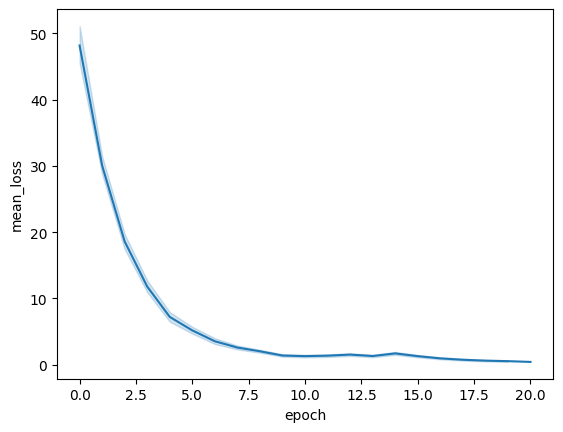

In [38]:
# Plot loss curve
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x='epoch', y='mean_loss')

last_epoch = snapshots['epoch'].max()
mean_loss_last_epoch = snapshots.loc[snapshots['epoch'] == last_epoch, 'mean_loss'].values[0]
print(f'last mean loss: {mean_loss_last_epoch}')
plt.show()

# last mean loss: 0.5540632


In [39]:
model = genai.GenerativeModel(model_name=f'tunedModels/distributed-fast-mixed')
result = model.generate_content('hi')

# Reformat with markdown
ans_formatted = f"{result.text}"
print(ans_formatted)

Hello! How can I assist you today?
